In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load dataset
file_path = '/content/drive/MyDrive/Minor_project6thsem/Datasets/DDOS SDN TREE TORUS /DDoS-SDN-Torus.csv'
df = pd.read_csv(file_path, low_memory=False)


In [ ]:
#  Preprocessing: Convert commas to dots & convert numeric columns
for col in df.columns:
    df[col] = df[col].astype(str).str.replace(',', '.')  # Fix decimal format
    try:
        df[col] = df[col].astype(float)  # Convert to float if possible
    except ValueError:
        pass  # Skip non-numeric columns

In [ ]:
#  Label Encoding for categorical target variable
if 'label' in df.columns:
    le = LabelEncoder()
    df['label'] = le.fit_transform(df['label'])  # Encode labels


<ipython-input-83-b997d77631fc>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['label'], palette="coolwarm")


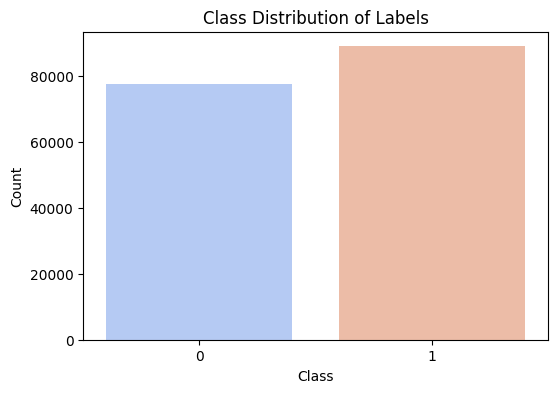

In [ ]:
# Visualize Class Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=df['label'], palette="coolwarm")
plt.title("Class Distribution of Labels")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

In [ ]:
#  Train-Test Split
X = df.drop(columns=['label'])  # Features
y = df['label']  # Target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
from sklearn.preprocessing import StandardScaler

# 🔹 Drop non-numeric columns
X_train_numeric = X_train.select_dtypes(include=['number'])
X_test_numeric = X_test.select_dtypes(include=['number'])

# 🔹 Apply StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_numeric)
X_test_scaled = scaler.transform(X_test_numeric)


In [ ]:
import pandas as pd
import numpy as np

# 🔹 Convert all non-numeric columns using Label Encoding
for col in X_train.select_dtypes(include=['object']).columns:
    X_train[col] = X_train[col].astype('category').cat.codes
    X_test[col] = X_test[col].astype('category').cat.codes

# 🔹 Convert DataFrame to NumPy array
X_train_np = X_train.to_numpy(dtype=np.float32)
X_test_np = X_test.to_numpy(dtype=np.float32)

# 🔹 Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_np, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_np, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)


In [ ]:
# Define Neural Network for Federated Learning
class FL_Model(nn.Module):
    def __init__(self, input_size, num_classes):
        super(FL_Model, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
# Initialize Model
input_size = X_train.shape[1]
num_classes = len(np.unique(y))
model = FL_Model(input_size, num_classes)

In [ ]:
# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Train Model
epochs = 10
train_losses = []
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")


Epoch [1/10], Loss: 5873788416.0000
Epoch [2/10], Loss: 2183490048.0000
Epoch [3/10], Loss: 1764255360.0000
Epoch [4/10], Loss: 490620224.0000
Epoch [5/10], Loss: 536328288.0000
Epoch [6/10], Loss: 550004224.0000
Epoch [7/10], Loss: 559232192.0000
Epoch [8/10], Loss: 562003264.0000
Epoch [9/10], Loss: 554132416.0000
Epoch [10/10], Loss: 548711936.0000


In [ ]:
# 🔹 12. Evaluate Model
with torch.no_grad():
    y_pred = model(X_test_tensor)
    y_pred_classes = torch.argmax(y_pred, dim=1)


In [ ]:
# Compute Accuracy
accuracy = accuracy_score(y_test, y_pred_classes.numpy())
print(f"✅ Model Accuracy: {accuracy:.4f}")

✅ Model Accuracy: 0.7507


In [ ]:
# Classification Report
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred_classes.numpy()))


📊 Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.84      0.76     15515
           1       0.83      0.68      0.74     17800

    accuracy                           0.75     33315
   macro avg       0.76      0.76      0.75     33315
weighted avg       0.76      0.75      0.75     33315



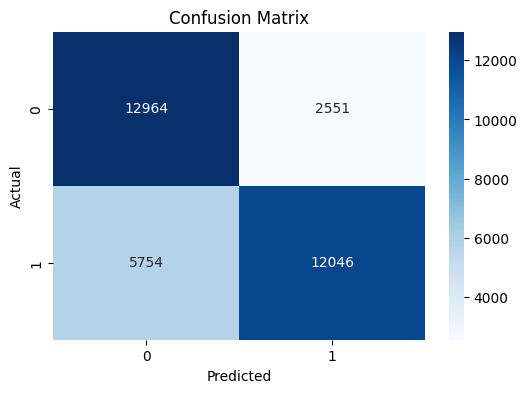

In [ ]:
# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes.numpy())
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

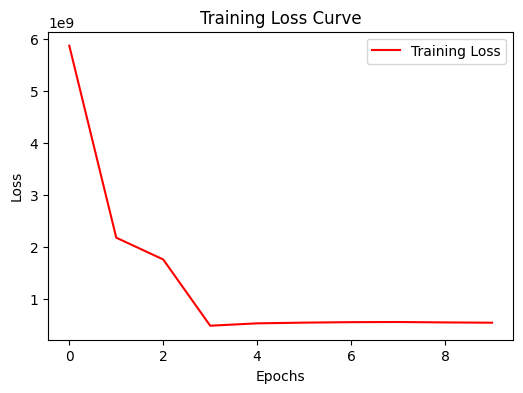

In [ ]:
#  Plot Loss Curve
plt.figure(figsize=(6, 4))
plt.plot(train_losses, label="Training Loss", color='r')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.show()